In [1]:
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import numpy as np
import io

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

torch.cuda.is_available()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
# !pip install transformers

In [ ]:
df = pd.read_csv("../../data/preprocessed_sub_and_body.csv")
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)
df.head()

Unnamed: 0  label                                         text
0           0      0  fw: june 29 -- bna, inc. daily labor report
1           1      0                           ngx failover plan.
2           2      0                            re: intranet site
3           3      0         fw: ena upstream company information
4           4      0                          new master physical

In [4]:
df["length"] = df["text"].apply(len)
df['length'].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

In [5]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.9 MB/s eta 0:00:00


In [6]:
from torchtext import data
from torchtext.vocab import Vocab
from collections import Counter
from nltk.tokenize import word_tokenize
import random

# drop unnecessary columns
df = df[['text', 'label']]

# save preprocessed data to a CSV file
df.to_csv("preprocessed_cleaned.csv", index=False)

# Field is standard column, LabelField is label column
# use spacy as tokenizer
TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', lower=True, include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, sequential=False, use_vocab=False, batch_first=True)

# цreate dataset
fields = [("body", TEXT), ("label", LABEL)]
dataset = data.TabularDataset(path="preprocessed_cleaned.csv", format="csv", fields=fields, skip_header=True)

# split dataset
train_data, val_data, test_data = dataset.split(split_ratio=[0.7, 0.1, 0.2], random_state=random.seed(42))

# build vocabulary, min word frequency is 5
TEXT.build_vocab(train_data, max_size=10000, min_freq=5)


In [7]:
class BiLSTMModel(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout1, dropout2
    ):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, batch_first=True, bidirectional=True
        )
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_dim * 2, 20)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(20, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, x_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden contains both forward and backward states for the last layer
        lstm_out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        lstm_out = self.dropout1(lstm_out)
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.dropout2(fc1_out)
        fc2_out = self.fc2(fc1_out)
        output = self.sigmoid(fc2_out)
        return output

In [8]:
embedding_dims = [32, 64]
hidden_dims = [100, 128]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.4]
n_epochs = 10

best_model = None
best_val_loss = float("inf")
results = []

In [9]:
from tqdm.auto import tqdm
import itertools
import torch.optim as optim

# BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grid search
for embedding_dim, hidden_dim, lr, batch_size, dropout1, dropout2 in itertools.product(
    embedding_dims,
    hidden_dims,
    learning_rates,
    batch_sizes,
    dropout_rates,
    dropout_rates,
):

    train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, val_data, test_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.body),
        sort_within_batch=True,
        device=device,
    )

    lstm_model = BiLSTMModel(
        len(TEXT.vocab), embedding_dim, hidden_dim, 1, dropout1, dropout2
    ).to(device)
    criterion = nn.BCELoss()
    criterion = criterion.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

    # early stopping criteria
    early_stopping_patience = 3
    best_epoch_val_loss = float("inf")
    epochs_no_improve = 0

    # TRAINING BLOCK
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):

        epoch_train_loss = 0
        lstm_model.train()

        with tqdm(train_iterator, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            for batch in tepoch:
                sequences, lengths = batch.body
                labels = batch.label
                optimizer.zero_grad()
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        train_losses.append(epoch_train_loss / len(train_iterator))

        print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)
        # TRAINING BLOCK ENDS
        print("Training complete!")

        # validation
        lstm_model.eval()
        epoch_val_loss = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_iterator:
                sequences, lengths = batch.body
                labels = batch.label
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                epoch_val_loss += loss.item()
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_losses.append(epoch_val_loss / len(val_iterator))

        print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")

        # early stopping
        if epoch_val_loss < best_epoch_val_loss:
            best_epoch_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # check if current model is the best
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = lstm_model

        # record hyperparameter configuration
        results.append(
            {
                "embedding_dim": embedding_dim,
                "hidden_dim": hidden_dim,
                "lr": lr,
                "batch_size": batch_size,
                "dropout1": dropout1,
                "dropout2": dropout2,
                "n_epochs": n_epochs,
                "train_loss": train_losses[-1],
                "val_loss": val_losses[-1],
            }
        )

best_hyperparams = min(results, key=lambda x: x["val_loss"])
print("Best Hyperparameters:")
print(best_hyperparams)

  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  54.36811736598611
Training complete!

Validation epoch 1 loss: 4.5612108036875725


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.73968247603625
Training complete!

Validation epoch 2 loss: 3.2625351515598595


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.829203241853975
Training complete!

Validation epoch 3 loss: 3.475543238222599


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.057576500694267
Training complete!

Validation epoch 4 loss: 3.9995252687949687


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.292320349140937
Training complete!

Validation epoch 5 loss: 4.056665604322916
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.007578529417515
Training complete!

Validation epoch 1 loss: 4.290655896067619


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.076596474274993
Training complete!

Validation epoch 2 loss: 3.749267654493451


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.021232856437564
Training complete!

Validation epoch 3 loss: 3.5649706618860364


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.793425082869362
Training complete!

Validation epoch 4 loss: 4.847238273825496


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.172089462765143
Training complete!

Validation epoch 5 loss: 5.138798455474898


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.983418451054604
Training complete!

Validation epoch 6 loss: 4.7384897073498
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  52.747697837650776
Training complete!

Validation epoch 1 loss: 3.616155631840229


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.738144602626562
Training complete!

Validation epoch 2 loss: 3.2822303753346205


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.375869340263307
Training complete!

Validation epoch 3 loss: 3.366084755398333


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.443550422089174
Training complete!

Validation epoch 4 loss: 4.14909156691283


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.9079080426272412
Training complete!

Validation epoch 5 loss: 4.6628526618587784
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.96332596242428
Training complete!

Validation epoch 1 loss: 4.122108720242977


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.367045806720853
Training complete!

Validation epoch 2 loss: 3.2112928237766027


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.91462726087775
Training complete!

Validation epoch 3 loss: 3.3810193184763193


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.055120354285464
Training complete!

Validation epoch 4 loss: 3.004566223360598


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.179883559067093
Training complete!

Validation epoch 5 loss: 3.543582750542555


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.8238440152272233
Training complete!

Validation epoch 6 loss: 4.464328994043171


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.9389050645768293
Training complete!

Validation epoch 7 loss: 5.022615033325565
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  30.611793011426926
Training complete!

Validation epoch 1 loss: 2.301170453429222


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.213761918246746
Training complete!

Validation epoch 2 loss: 1.6597441509366035


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.092649433761835
Training complete!

Validation epoch 3 loss: 1.692379366606474


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.756942272186279
Training complete!

Validation epoch 4 loss: 1.7924799304455519


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.1331381804775447
Training complete!

Validation epoch 5 loss: 2.031666395254433
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.466022327542305
Training complete!

Validation epoch 1 loss: 2.3158519938588142


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.034969557076693
Training complete!

Validation epoch 2 loss: 1.6092808917164803


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.840962917543948
Training complete!

Validation epoch 3 loss: 1.7559701688587666


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.076629496645182
Training complete!

Validation epoch 4 loss: 2.082983209285885


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.195458637259435
Training complete!

Validation epoch 5 loss: 2.7275991924107075
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  29.45104268938303
Training complete!

Validation epoch 1 loss: 2.110465981066227


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.0719278678298
Training complete!

Validation epoch 2 loss: 1.6703526973724365


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.377668337896466
Training complete!

Validation epoch 3 loss: 1.8794993869960308


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.675064617302269
Training complete!

Validation epoch 4 loss: 2.2647750694304705


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.1892901182873175
Training complete!

Validation epoch 5 loss: 2.3440793971531093
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  29.618827015161514
Training complete!

Validation epoch 1 loss: 2.2422656640410423


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.831296354532242
Training complete!

Validation epoch 2 loss: 1.7553033828735352


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.626675111241639
Training complete!

Validation epoch 3 loss: 1.8141145594418049


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.516738576814532
Training complete!

Validation epoch 4 loss: 1.9265551678836346


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0243054850725457
Training complete!

Validation epoch 5 loss: 2.4399455711245537
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  66.71061778068542
Training complete!

Validation epoch 1 loss: 5.721154145896435


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  59.32591215521097
Training complete!

Validation epoch 2 loss: 5.770063817501068


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  45.43673050403595
Training complete!

Validation epoch 3 loss: 4.806374698877335


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  34.39744393900037
Training complete!

Validation epoch 4 loss: 4.240082509815693


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  29.528245074674487
Training complete!

Validation epoch 5 loss: 4.013692654669285


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  30.036041850224137
Training complete!

Validation epoch 6 loss: 5.555236130952835


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  28.982951875776052
Training complete!

Validation epoch 7 loss: 4.026760995388031


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  21.368355155922472
Training complete!

Validation epoch 8 loss: 3.813382176682353


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  18.262810735963285
Training complete!

Validation epoch 9 loss: 3.7042845711112022


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.06981064286083
Training complete!

Validation epoch 10 loss: 3.752583891618997


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  71.44971273839474
Training complete!

Validation epoch 1 loss: 5.902191944420338


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  42.53290571644902
Training complete!

Validation epoch 2 loss: 5.3485285341739655


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  35.006834626197815
Training complete!

Validation epoch 3 loss: 4.433565191924572


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  28.167448641732335
Training complete!

Validation epoch 4 loss: 4.115592126036063


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.013761339709163
Training complete!

Validation epoch 5 loss: 4.091610522940755


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  21.895283075980842
Training complete!

Validation epoch 6 loss: 3.9288149513304234


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.019328623544425
Training complete!

Validation epoch 7 loss: 3.6146901887841523


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.537664538482204
Training complete!

Validation epoch 8 loss: 3.731913087889552


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.687834230484441
Training complete!

Validation epoch 9 loss: 3.62871751273633


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.977855854172958
Training complete!

Validation epoch 10 loss: 3.5359506695822347


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  71.66678522527218
Training complete!

Validation epoch 1 loss: 6.111537992954254


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  43.926244258880615
Training complete!

Validation epoch 2 loss: 4.769342236220837


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.07379826158285
Training complete!

Validation epoch 3 loss: 4.3922126442193985


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  29.16038833372295
Training complete!

Validation epoch 4 loss: 4.560267224907875


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  24.60065457969904
Training complete!

Validation epoch 5 loss: 3.674201127141714


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  22.308648644248024
Training complete!

Validation epoch 6 loss: 3.8974504619836807


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.216226307675242
Training complete!

Validation epoch 7 loss: 3.644335367716849


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  12.993831393774599
Training complete!

Validation epoch 8 loss: 3.580605920404196


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.929983871872537
Training complete!

Validation epoch 9 loss: 4.335374529939145


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.489081310806796
Training complete!

Validation epoch 10 loss: 3.951876769308001


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  70.52303531765938
Training complete!

Validation epoch 1 loss: 6.581578925251961


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  54.66587829589844
Training complete!

Validation epoch 2 loss: 5.652784034609795


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  38.67058487609029
Training complete!

Validation epoch 3 loss: 4.720828399062157


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  32.359423238784075
Training complete!

Validation epoch 4 loss: 4.375240289606154


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  26.63429100252688
Training complete!

Validation epoch 5 loss: 4.0655012503266335


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  23.48609791463241
Training complete!

Validation epoch 6 loss: 3.8920768396928906


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  19.883999933488667
Training complete!

Validation epoch 7 loss: 3.721709990873933


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  17.367056478280574
Training complete!

Validation epoch 8 loss: 3.8961605140939355


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.193102690624073
Training complete!

Validation epoch 9 loss: 3.9142423192970455


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  11.737950591137633
Training complete!

Validation epoch 10 loss: 4.057390227797441
Early stopping triggered at epoch 10


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  40.32795387506485
Training complete!

Validation epoch 1 loss: 3.978788375854492


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.88672959804535
Training complete!

Validation epoch 2 loss: 2.884965479373932


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.558438941836357
Training complete!

Validation epoch 3 loss: 2.4442242980003357


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.308595784008503
Training complete!

Validation epoch 4 loss: 2.1868010610342026


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.07072463259101
Training complete!

Validation epoch 5 loss: 2.0778576731681824


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.647778868675232
Training complete!

Validation epoch 6 loss: 2.021916676312685


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.724798576906323
Training complete!

Validation epoch 7 loss: 1.9907832965254784


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.585239168256521
Training complete!

Validation epoch 8 loss: 1.8125916197896004


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.06603537965566
Training complete!

Validation epoch 9 loss: 1.9569367468357086


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.07117657084018
Training complete!

Validation epoch 10 loss: 1.8648584596812725


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.63396528363228
Training complete!

Validation epoch 1 loss: 3.660286545753479


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.444453358650208
Training complete!

Validation epoch 2 loss: 2.6830528527498245


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.99108573794365
Training complete!

Validation epoch 3 loss: 2.433883771300316


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.798509888350964
Training complete!

Validation epoch 4 loss: 2.213115982711315


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.959437686949968
Training complete!

Validation epoch 5 loss: 2.1120899133384228


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.401180628687143
Training complete!

Validation epoch 6 loss: 1.9918854404240847


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  11.519043629057705
Training complete!

Validation epoch 7 loss: 1.9020227491855621


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.394476732239127
Training complete!

Validation epoch 8 loss: 1.9899235367774963


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.399371857754886
Training complete!

Validation epoch 9 loss: 1.894927004352212


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.472728581633419
Training complete!

Validation epoch 10 loss: 1.9746094457805157


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  40.13889068365097
Training complete!

Validation epoch 1 loss: 3.441875010728836


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.134301275014877
Training complete!

Validation epoch 2 loss: 2.711764082312584


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.02177481353283
Training complete!

Validation epoch 3 loss: 2.312832921743393


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  18.2915752902627
Training complete!

Validation epoch 4 loss: 2.108893759548664


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.436921168118715
Training complete!

Validation epoch 5 loss: 2.0255554988980293


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.2035281509161
Training complete!

Validation epoch 6 loss: 1.969673290848732


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.070362359285355
Training complete!

Validation epoch 7 loss: 1.913035735487938


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.488995517604053
Training complete!

Validation epoch 8 loss: 1.8484211936593056


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.595266185700893
Training complete!

Validation epoch 9 loss: 1.835218209773302


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.810788221191615
Training complete!

Validation epoch 10 loss: 1.7695472985506058


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  40.35379374027252
Training complete!

Validation epoch 1 loss: 3.6331570744514465


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.159213602542877
Training complete!

Validation epoch 2 loss: 3.207749620079994


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.59917813539505
Training complete!

Validation epoch 3 loss: 2.5576863884925842


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.32021750509739
Training complete!

Validation epoch 4 loss: 2.2952832132577896


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.140448302030563
Training complete!

Validation epoch 5 loss: 2.0375860407948494


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.856475472450256
Training complete!

Validation epoch 6 loss: 1.9754884466528893


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.011497501283884
Training complete!

Validation epoch 7 loss: 1.8869645409286022


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.355884306132793
Training complete!

Validation epoch 8 loss: 1.89713563490659


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.61579484026879
Training complete!

Validation epoch 9 loss: 1.8311746753752232


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.042044225148857
Training complete!

Validation epoch 10 loss: 1.8318582251667976


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.92737115174532
Training complete!

Validation epoch 1 loss: 3.763106256723404


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.909295607358217
Training complete!

Validation epoch 2 loss: 3.4482091292738914


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.569806422339752
Training complete!

Validation epoch 3 loss: 3.80714666377753


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.523181467666291
Training complete!

Validation epoch 4 loss: 4.017417934839614


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.536764802178368
Training complete!

Validation epoch 5 loss: 4.875711312284693
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.35484400391579
Training complete!

Validation epoch 1 loss: 4.296707555651665


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.110203929245472
Training complete!

Validation epoch 2 loss: 3.5679060611873865


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.00813769584056
Training complete!

Validation epoch 3 loss: 3.6588727009948343


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.043896734481677
Training complete!

Validation epoch 4 loss: 3.9860441628843546


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.864197122256883
Training complete!

Validation epoch 5 loss: 4.145475779543631
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.688128024339676
Training complete!

Validation epoch 1 loss: 4.201146692037582


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.551818393170834
Training complete!

Validation epoch 2 loss: 2.9477894185110927


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.315615184605122
Training complete!

Validation epoch 3 loss: 3.5859828661195934


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.169145469320938
Training complete!

Validation epoch 4 loss: 3.728726428002119


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.198887156002456
Training complete!

Validation epoch 5 loss: 4.635279234498739
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.7841225117445
Training complete!

Validation epoch 1 loss: 3.6583026945590973


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.149387946352363
Training complete!

Validation epoch 2 loss: 3.298859167844057


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.438406872563064
Training complete!

Validation epoch 3 loss: 3.28995905444026


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.465209573390894
Training complete!

Validation epoch 4 loss: 3.7648665411397815


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.769024410824841
Training complete!

Validation epoch 5 loss: 4.683900030795485


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.062388778770355
Training complete!

Validation epoch 6 loss: 4.866121409693733
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.05426223576069
Training complete!

Validation epoch 1 loss: 3.2968191504478455


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.385496385395527
Training complete!

Validation epoch 2 loss: 2.378530792891979


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.86379911005497
Training complete!

Validation epoch 3 loss: 2.35260359197855


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.578198097646236
Training complete!

Validation epoch 4 loss: 2.050391748547554


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.0011838069185615
Training complete!

Validation epoch 5 loss: 2.0312860291451216


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.358896052232012
Training complete!

Validation epoch 6 loss: 1.870308680459857


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.2809154980350286
Training complete!

Validation epoch 7 loss: 2.8110760264098644


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  2.7682009427808225
Training complete!

Validation epoch 8 loss: 2.1245760042220354


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  1.9827815546886995
Training complete!

Validation epoch 9 loss: 2.555215022293851
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.784407779574394
Training complete!

Validation epoch 1 loss: 2.2467965334653854


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.22453421354294
Training complete!

Validation epoch 2 loss: 1.8776828348636627


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.552963949739933
Training complete!

Validation epoch 3 loss: 1.9167642705142498


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.431473666802049
Training complete!

Validation epoch 4 loss: 1.7197846323251724


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.6127765141427517
Training complete!

Validation epoch 5 loss: 1.8753726817667484


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.7301728823804297
Training complete!

Validation epoch 6 loss: 1.7460346557199955


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.017452440748457
Training complete!

Validation epoch 7 loss: 1.9200781919062138
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.037185817956924
Training complete!

Validation epoch 1 loss: 2.421382322907448


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.857258718460798
Training complete!

Validation epoch 2 loss: 1.6722990795969963


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.778545780107379
Training complete!

Validation epoch 3 loss: 1.9042349383234978


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.92451733071357
Training complete!

Validation epoch 4 loss: 1.933035595342517


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.020857980940491
Training complete!

Validation epoch 5 loss: 1.99746960029006
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.7064650952816
Training complete!

Validation epoch 1 loss: 2.1896392479538918


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.935962654650211
Training complete!

Validation epoch 2 loss: 1.7403960973024368


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.099702589213848
Training complete!

Validation epoch 3 loss: 1.4505424741655588


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.462092308793217
Training complete!

Validation epoch 4 loss: 1.5345602501183748


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.241675404133275
Training complete!

Validation epoch 5 loss: 1.7299008102854714


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.310635154892225
Training complete!

Validation epoch 6 loss: 1.5628523901104927
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  66.77615565061569
Training complete!

Validation epoch 1 loss: 5.382693774998188


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  42.57867293804884
Training complete!

Validation epoch 2 loss: 5.0557239800691605


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  32.89992694929242
Training complete!

Validation epoch 3 loss: 4.0152414329349995


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.084854836575687
Training complete!

Validation epoch 4 loss: 3.6843623565509915


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.9236674066633
Training complete!

Validation epoch 5 loss: 3.6916060652583838


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.186148080043495
Training complete!

Validation epoch 6 loss: 3.5524850240908563


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.794590729521587
Training complete!

Validation epoch 7 loss: 4.002968443266582


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.341875885846093
Training complete!

Validation epoch 8 loss: 3.7814637251431122


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.735488608013839
Training complete!

Validation epoch 9 loss: 4.1679190821014345
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  69.11161830276251
Training complete!

Validation epoch 1 loss: 6.020258769392967


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  42.86891308426857
Training complete!

Validation epoch 2 loss: 4.844960778951645


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.49438360333443
Training complete!

Validation epoch 3 loss: 4.171483084559441


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.32652046531439
Training complete!

Validation epoch 4 loss: 4.039320711046457


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  26.915853176265955
Training complete!

Validation epoch 5 loss: 4.1417382173240185


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.89428306138143
Training complete!

Validation epoch 6 loss: 3.6001307982951403


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.485142709687352
Training complete!

Validation epoch 7 loss: 3.649365088902414


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  13.554190952330828
Training complete!

Validation epoch 8 loss: 3.7244340360630304


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  11.580316915526055
Training complete!

Validation epoch 9 loss: 4.408693216741085
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  68.52247712761164
Training complete!

Validation epoch 1 loss: 5.714566484093666


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  45.16928385198116
Training complete!

Validation epoch 2 loss: 5.761932730674744


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  39.0800741687417
Training complete!

Validation epoch 3 loss: 4.473449472337961


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.815751563757658
Training complete!

Validation epoch 4 loss: 4.178441856056452


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.19568814150989
Training complete!

Validation epoch 5 loss: 4.039659794420004


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  21.34430746315047
Training complete!

Validation epoch 6 loss: 3.73336086794734


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.62669330649078
Training complete!

Validation epoch 7 loss: 4.0601974837481976


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.851954000070691
Training complete!

Validation epoch 8 loss: 3.8024141620844603


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  13.383091454626992
Training complete!

Validation epoch 9 loss: 4.046697845682502
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  67.96827064454556
Training complete!

Validation epoch 1 loss: 6.141663447022438


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  44.13282470405102
Training complete!

Validation epoch 2 loss: 5.144272536039352


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.23084854800254
Training complete!

Validation epoch 3 loss: 4.885370746254921


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.791307305917144
Training complete!

Validation epoch 4 loss: 4.038627780973911


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.995876470580697
Training complete!

Validation epoch 5 loss: 3.5742844063788652


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  19.775298228953034
Training complete!

Validation epoch 6 loss: 3.6826084163039923


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  19.19184884382412
Training complete!

Validation epoch 7 loss: 3.4809378534555435


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.109656253131106
Training complete!

Validation epoch 8 loss: 3.3234139336273074


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  11.78653336968273
Training complete!

Validation epoch 9 loss: 3.522519830148667


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.771919206599705
Training complete!

Validation epoch 10 loss: 3.79162116907537


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  38.90090975165367
Training complete!

Validation epoch 1 loss: 3.4466343820095062


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.614064037799835
Training complete!

Validation epoch 2 loss: 3.8080429136753082


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.007278695702553
Training complete!

Validation epoch 3 loss: 2.1521088033914566


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  16.88602839782834
Training complete!

Validation epoch 4 loss: 1.9531964287161827


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.05824713036418
Training complete!

Validation epoch 5 loss: 2.1344797164201736


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.760117750614882
Training complete!

Validation epoch 6 loss: 1.8013528548181057


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  11.263253175653517
Training complete!

Validation epoch 7 loss: 1.7106765173375607


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  9.991136198863387
Training complete!

Validation epoch 8 loss: 1.6643795538693666


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  7.979586246423423
Training complete!

Validation epoch 9 loss: 1.658874062821269


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.390440156683326
Training complete!

Validation epoch 10 loss: 1.7397120855748653


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.20111891627312
Training complete!

Validation epoch 1 loss: 3.4822218120098114


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.232842072844505
Training complete!

Validation epoch 2 loss: 2.640642300248146


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.61234451830387
Training complete!

Validation epoch 3 loss: 2.390184201300144


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.349451832473278
Training complete!

Validation epoch 4 loss: 2.1025009974837303


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.862672332674265
Training complete!

Validation epoch 5 loss: 2.155273273587227


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.748530700802803
Training complete!

Validation epoch 6 loss: 1.9528087452054024


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  11.629665998741984
Training complete!

Validation epoch 7 loss: 1.918194055557251


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.08498289436102
Training complete!

Validation epoch 8 loss: 1.8513484355062246


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.31112705776468
Training complete!

Validation epoch 9 loss: 1.7986903712153435


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.55694628925994
Training complete!

Validation epoch 10 loss: 1.8941790089011192


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.80266681313515
Training complete!

Validation epoch 1 loss: 3.413042277097702


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.47788195312023
Training complete!

Validation epoch 2 loss: 2.5661283135414124


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.49470204859972
Training complete!

Validation epoch 3 loss: 2.3438054099678993


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.19388286024332
Training complete!

Validation epoch 4 loss: 2.337544783949852


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  19.989037699997425
Training complete!

Validation epoch 5 loss: 2.1939883157610893


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.746019966900349
Training complete!

Validation epoch 6 loss: 2.1277303770184517


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.072410881519318
Training complete!

Validation epoch 7 loss: 2.002050619572401


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.733731005340815
Training complete!

Validation epoch 8 loss: 1.8393421806395054


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  8.87465706281364
Training complete!

Validation epoch 9 loss: 1.8656206019222736


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.6100125992670655
Training complete!

Validation epoch 10 loss: 1.8520926404744387


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  40.21428084373474
Training complete!

Validation epoch 1 loss: 3.9072645902633667


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.982384651899338
Training complete!

Validation epoch 2 loss: 2.909116268157959


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.03155153989792
Training complete!

Validation epoch 3 loss: 2.261843763291836


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  17.73187230527401
Training complete!

Validation epoch 4 loss: 2.036035604774952


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.03139210678637
Training complete!

Validation epoch 5 loss: 1.9117687735706568


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  15.557503186166286
Training complete!

Validation epoch 6 loss: 2.182793974876404


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.14799821190536
Training complete!

Validation epoch 7 loss: 1.8451970033347607


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  10.406992399133742
Training complete!

Validation epoch 8 loss: 1.8306428035721183


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.191355029121041
Training complete!

Validation epoch 9 loss: 1.8598399246111512


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  7.524149000644684
Training complete!

Validation epoch 10 loss: 1.8841019980609417


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  47.17121912166476
Training complete!

Validation epoch 1 loss: 3.4400562774389982


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.610027875751257
Training complete!

Validation epoch 2 loss: 2.9167099380865693


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.786796559812501
Training complete!

Validation epoch 3 loss: 3.369659554155078


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.824136945826467
Training complete!

Validation epoch 4 loss: 3.9817039722111076


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.771594140300294
Training complete!

Validation epoch 5 loss: 4.088722918590065
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  47.760721914470196
Training complete!

Validation epoch 1 loss: 3.801262278109789


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.318784174509346
Training complete!

Validation epoch 2 loss: 3.246250666677952


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.801941438985523
Training complete!

Validation epoch 3 loss: 3.648646035755519


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.696987421484664
Training complete!

Validation epoch 4 loss: 4.467415688559413


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.837770522746723
Training complete!

Validation epoch 5 loss: 5.117888713721186
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  47.25818868353963
Training complete!

Validation epoch 1 loss: 4.046837665140629


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.523843503324315
Training complete!

Validation epoch 2 loss: 3.296658594161272


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.663324059452862
Training complete!

Validation epoch 3 loss: 3.432555692270398


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.40805698686745
Training complete!

Validation epoch 4 loss: 3.2611738592386246


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.512961463071406
Training complete!

Validation epoch 5 loss: 3.922139920076006


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.219990258843609
Training complete!

Validation epoch 6 loss: 3.728168151952559


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.160243497177362
Training complete!

Validation epoch 7 loss: 4.624750382325146
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.55718023702502
Training complete!

Validation epoch 1 loss: 3.880215000361204


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.026209272444248
Training complete!

Validation epoch 2 loss: 3.1945035085082054


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.318523217691109
Training complete!

Validation epoch 3 loss: 3.2945462497882545


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.195908383699134
Training complete!

Validation epoch 4 loss: 4.019440170726739


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.873181598071824
Training complete!

Validation epoch 5 loss: 3.964516313164495
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  26.033883780241013
Training complete!

Validation epoch 1 loss: 1.9321919232606888


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.217108398675919
Training complete!

Validation epoch 2 loss: 1.5308863148093224


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  7.197270609438419
Training complete!

Validation epoch 3 loss: 1.69985331594944


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.5306179912295192
Training complete!

Validation epoch 4 loss: 2.0591241158545017


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.129754906432936
Training complete!

Validation epoch 5 loss: 2.378683446906507
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  26.272197000682354
Training complete!

Validation epoch 1 loss: 2.2557947486639023


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.825689438730478
Training complete!

Validation epoch 2 loss: 1.7239834684878588


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.302460664883256
Training complete!

Validation epoch 3 loss: 1.8506388431414962


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.9891647272743285
Training complete!

Validation epoch 4 loss: 2.0049178027547896


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.5281704536173493
Training complete!

Validation epoch 5 loss: 2.454763519577682
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  30.915245555341244
Training complete!

Validation epoch 1 loss: 2.1041615679860115


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.630388800054789
Training complete!

Validation epoch 2 loss: 1.5383327938616276


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.21546024363488
Training complete!

Validation epoch 3 loss: 1.6932405941188335


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.175183860817924
Training complete!

Validation epoch 4 loss: 1.958804804366082


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.0177451397757977
Training complete!

Validation epoch 5 loss: 2.488715212792158
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  27.006809249520302
Training complete!

Validation epoch 1 loss: 2.1015820652246475


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.886190135031939
Training complete!

Validation epoch 2 loss: 1.7580445781350136


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  5.956928540021181
Training complete!

Validation epoch 3 loss: 1.782387301325798


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.0676586027257144
Training complete!

Validation epoch 4 loss: 1.9811177933588624


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.15838225238258
Training complete!

Validation epoch 5 loss: 2.2962629348039627
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.741665817797184
Training complete!

Validation epoch 1 loss: 4.834515407681465


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  35.907469157129526
Training complete!

Validation epoch 2 loss: 4.115296617150307


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.09507775492966
Training complete!

Validation epoch 3 loss: 3.545734449289739


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.027206507511437
Training complete!

Validation epoch 4 loss: 3.337661783210933


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  14.620404103188775
Training complete!

Validation epoch 5 loss: 3.3479576595127583


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  11.355031455343124
Training complete!

Validation epoch 6 loss: 3.3641098246444017


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.01037375627493
Training complete!

Validation epoch 7 loss: 3.9959936015948188
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  66.84541976451874
Training complete!

Validation epoch 1 loss: 5.430146098136902


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  38.62281420826912
Training complete!

Validation epoch 2 loss: 4.2191727086901665


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.08355061803013
Training complete!

Validation epoch 3 loss: 3.667282236739993


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.93415400199592
Training complete!

Validation epoch 4 loss: 3.429468434303999


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.678151051979512
Training complete!

Validation epoch 5 loss: 3.644373409450054


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.522372306790203
Training complete!

Validation epoch 6 loss: 3.415553290396929


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.409775312524289
Training complete!

Validation epoch 7 loss: 3.82968919724226


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.658485076215584
Training complete!

Validation epoch 8 loss: 4.1164100375026464


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  6.041949981619837
Training complete!

Validation epoch 9 loss: 5.020337929949164
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  62.16416025906801
Training complete!

Validation epoch 1 loss: 4.992470130324364


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.27840708941221
Training complete!

Validation epoch 2 loss: 4.604782219976187


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.350606508553028
Training complete!

Validation epoch 3 loss: 3.766118559986353


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.08195731509477
Training complete!

Validation epoch 4 loss: 3.6033300179988146


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.624868597486056
Training complete!

Validation epoch 5 loss: 3.652868878096342


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  11.912474548560567
Training complete!

Validation epoch 6 loss: 3.6656503952108324


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.592893132590689
Training complete!

Validation epoch 7 loss: 3.696897015790455
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.097347907722
Training complete!

Validation epoch 1 loss: 5.08515764772892


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.01937235146761
Training complete!

Validation epoch 2 loss: 4.104049134999514


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  26.33254446554929
Training complete!

Validation epoch 3 loss: 3.445057055912912


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.734570864588022
Training complete!

Validation epoch 4 loss: 3.3360526459291577


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.46637477632612
Training complete!

Validation epoch 5 loss: 3.3065335704013705


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.415022250497714
Training complete!

Validation epoch 6 loss: 3.842024341225624


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.976208123698598
Training complete!

Validation epoch 7 loss: 3.4731525289826095


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.370263312104726
Training complete!

Validation epoch 8 loss: 3.9717741053318605
Early stopping triggered at epoch 8


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.409210339188576
Training complete!

Validation epoch 1 loss: 3.1081355810165405


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.577851347625256
Training complete!

Validation epoch 2 loss: 2.2356020882725716


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.755142964422703
Training complete!

Validation epoch 3 loss: 1.9871559143066406


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.578458297997713
Training complete!

Validation epoch 4 loss: 1.7481193207204342


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.377607070840895
Training complete!

Validation epoch 5 loss: 1.769284438341856


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.45896113384515
Training complete!

Validation epoch 6 loss: 1.6748074470087886


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.6268957974389195
Training complete!

Validation epoch 7 loss: 1.678395910654217


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.5517237656749785
Training complete!

Validation epoch 8 loss: 1.9256272409111261


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.044401828141417
Training complete!

Validation epoch 9 loss: 1.7568742488510907
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.229024186730385
Training complete!

Validation epoch 1 loss: 2.91172094643116


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.504042744636536
Training complete!

Validation epoch 2 loss: 2.28651412576437


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.15807791799307
Training complete!

Validation epoch 3 loss: 2.0443783029913902


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.684880189597607
Training complete!

Validation epoch 4 loss: 2.094110205769539


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  12.279039602726698
Training complete!

Validation epoch 5 loss: 1.9218131452798843


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  10.129782374948263
Training complete!

Validation epoch 6 loss: 1.7659319229424


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.86641481751576
Training complete!

Validation epoch 7 loss: 1.8306278139352798


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  7.366371585521847
Training complete!

Validation epoch 8 loss: 1.7977317497134209


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.8188658317085356
Training complete!

Validation epoch 9 loss: 1.678562588058412


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  4.3283472340554
Training complete!

Validation epoch 10 loss: 1.699947007931769


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.387528002262115
Training complete!

Validation epoch 1 loss: 3.821757674217224


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.84739598631859
Training complete!

Validation epoch 2 loss: 2.189160704612732


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.319677744060755
Training complete!

Validation epoch 3 loss: 2.0047090500593185


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.271319415420294
Training complete!

Validation epoch 4 loss: 1.835257412865758


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.85097561776638
Training complete!

Validation epoch 5 loss: 1.7086098492145538


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.373834252357483
Training complete!

Validation epoch 6 loss: 1.6864531487226486


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.274686131859198
Training complete!

Validation epoch 7 loss: 1.726475453004241


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  7.329042596742511
Training complete!

Validation epoch 8 loss: 1.6331908348947763


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.539541421458125
Training complete!

Validation epoch 9 loss: 1.7855666605755687


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  4.079716542153619
Training complete!

Validation epoch 10 loss: 2.0372067959979177


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  37.95752353966236
Training complete!

Validation epoch 1 loss: 2.7716290056705475


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.66472875326872
Training complete!

Validation epoch 2 loss: 2.3071228116750717


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.852182984352112
Training complete!

Validation epoch 3 loss: 1.9913883358240128


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.5372234005481
Training complete!

Validation epoch 4 loss: 1.813479658216238


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  13.61921800673008
Training complete!

Validation epoch 5 loss: 1.8381491675972939


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.25618408061564
Training complete!

Validation epoch 6 loss: 1.6546991094946861


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.661003613844514
Training complete!

Validation epoch 7 loss: 1.6606420613825321


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.176532880868763
Training complete!

Validation epoch 8 loss: 1.7042156755924225


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.016008683713153
Training complete!

Validation epoch 9 loss: 1.841171644628048
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  48.766052193939686
Training complete!

Validation epoch 1 loss: 3.6517804097384214


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.60170134715736
Training complete!

Validation epoch 2 loss: 3.1531936787068844


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.234850089414977
Training complete!

Validation epoch 3 loss: 6.536705732345581


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.006641183310421
Training complete!

Validation epoch 4 loss: 4.111634869128466


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.3571207180502824
Training complete!

Validation epoch 5 loss: 5.398213632201077
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  50.242646276950836
Training complete!

Validation epoch 1 loss: 3.2422847729176283


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.8803894771263
Training complete!

Validation epoch 2 loss: 2.667492049280554


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.95506968582049
Training complete!

Validation epoch 3 loss: 3.45840285718441


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.363087423298566
Training complete!

Validation epoch 4 loss: 3.954753341298783


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.9812510246920283
Training complete!

Validation epoch 5 loss: 4.819889478123514
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  52.2467660009861
Training complete!

Validation epoch 1 loss: 4.164298176765442


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.31303335353732
Training complete!

Validation epoch 2 loss: 2.918380556628108


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.388142725685611
Training complete!

Validation epoch 3 loss: 4.466946372762322


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.691771391953807
Training complete!

Validation epoch 4 loss: 4.021366952452809


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.782793899052194
Training complete!

Validation epoch 5 loss: 4.502901205290982
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  53.86586944013834
Training complete!

Validation epoch 1 loss: 3.5085613653063774


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.600244676694274
Training complete!

Validation epoch 2 loss: 2.950172111392021


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.68055819440633
Training complete!

Validation epoch 3 loss: 3.157982241595164


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.38272345054429
Training complete!

Validation epoch 4 loss: 3.928134328685701


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.1057205980760045
Training complete!

Validation epoch 5 loss: 4.740962149371626
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  28.48012136667967
Training complete!

Validation epoch 1 loss: 1.998668611049652


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.323891755193472
Training complete!

Validation epoch 2 loss: 1.8566957153379917


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.463586977683008
Training complete!

Validation epoch 3 loss: 1.7131791049614549


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  2.881058394559659
Training complete!

Validation epoch 4 loss: 2.3042026115581393


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.8254323401197325
Training complete!

Validation epoch 5 loss: 2.6204629614949226


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.4034263330249814
Training complete!

Validation epoch 6 loss: 2.703327273018658
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  26.347612500190735
Training complete!

Validation epoch 1 loss: 2.046997033059597


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  12.677081376314163
Training complete!

Validation epoch 2 loss: 1.763881728053093


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.366634984500706
Training complete!

Validation epoch 3 loss: 1.6725097903981805


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.436446732841432
Training complete!

Validation epoch 4 loss: 1.8716007401235402


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  1.9265836919366848
Training complete!

Validation epoch 5 loss: 2.0453584492206573


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  1.4363387331104605
Training complete!

Validation epoch 6 loss: 1.8514866116456687
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  27.510396108031273
Training complete!

Validation epoch 1 loss: 2.2414054721593857


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.963966887444258
Training complete!

Validation epoch 2 loss: 2.000576801598072


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.797573210671544
Training complete!

Validation epoch 3 loss: 2.1457040831446648


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  4.932477436494082
Training complete!

Validation epoch 4 loss: 1.8456329880282283


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.292154020862654
Training complete!

Validation epoch 5 loss: 2.1872768327593803


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  2.1065831548767164
Training complete!

Validation epoch 6 loss: 2.3612137511372566


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  2.198795528849587
Training complete!

Validation epoch 7 loss: 2.628492422401905
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  27.665671601891518
Training complete!

Validation epoch 1 loss: 1.9350106716156006


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  11.583575990051031
Training complete!

Validation epoch 2 loss: 1.5409529991447926


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  6.252297663595527
Training complete!

Validation epoch 3 loss: 1.8370304629206657


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  3.6877945770975202
Training complete!

Validation epoch 4 loss: 1.738077406771481


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  2.4531550679239444
Training complete!

Validation epoch 5 loss: 2.109559763222933
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.61204606294632
Training complete!

Validation epoch 1 loss: 4.99447625875473


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  39.04573565162718
Training complete!

Validation epoch 2 loss: 4.127623066306114


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.9890207182616
Training complete!

Validation epoch 3 loss: 3.466503832489252


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.240132480859756
Training complete!

Validation epoch 4 loss: 3.7074075546115637


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.361204865854234
Training complete!

Validation epoch 5 loss: 3.8619451988488436


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  12.123855996702332
Training complete!

Validation epoch 6 loss: 3.3649595556780696


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.335235903679859
Training complete!

Validation epoch 7 loss: 3.7554310094565153


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.430480670067482
Training complete!

Validation epoch 8 loss: 5.454740228247829


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.134371313306474
Training complete!

Validation epoch 9 loss: 5.692469866015017
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.43922105431557
Training complete!

Validation epoch 1 loss: 5.80380991846323


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  40.27729444950819
Training complete!

Validation epoch 2 loss: 5.419869109988213


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  32.71392922848463
Training complete!

Validation epoch 3 loss: 4.68600170314312


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  26.27918640896678
Training complete!

Validation epoch 4 loss: 3.9794428944587708


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.1611815597862
Training complete!

Validation epoch 5 loss: 3.384412592276931


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.659234376857057
Training complete!

Validation epoch 6 loss: 3.2732076682150364


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  10.944935663370416
Training complete!

Validation epoch 7 loss: 3.2916633980348706


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  7.7894268858945
Training complete!

Validation epoch 8 loss: 3.5923002306371927


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.957284490708844
Training complete!

Validation epoch 9 loss: 3.747613890096545
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.2304932847619
Training complete!

Validation epoch 1 loss: 4.916842356324196


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.63650518655777
Training complete!

Validation epoch 2 loss: 3.972779542207718


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  26.499938720837235
Training complete!

Validation epoch 3 loss: 3.5308056380599737


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.62801824323833
Training complete!

Validation epoch 4 loss: 3.4633622262626886


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.038796227658167
Training complete!

Validation epoch 5 loss: 3.511350316926837


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.973650353727862
Training complete!

Validation epoch 6 loss: 3.513816975057125


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.933767351089045
Training complete!

Validation epoch 7 loss: 4.011284013278782
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  65.79700995981693
Training complete!

Validation epoch 1 loss: 5.315733514726162


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.559853926301
Training complete!

Validation epoch 2 loss: 4.14308924973011


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  29.83161384612322
Training complete!

Validation epoch 3 loss: 4.075403440743685


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  22.274900373071432
Training complete!

Validation epoch 4 loss: 3.744844913482666


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  18.651906402315944
Training complete!

Validation epoch 5 loss: 3.5517737977206707


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.13674882450141
Training complete!

Validation epoch 6 loss: 3.6622318769805133


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  9.410296850139275
Training complete!

Validation epoch 7 loss: 4.010140498459805


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  6.908686940543703
Training complete!

Validation epoch 8 loss: 4.316928682848811
Early stopping triggered at epoch 8


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.78714057803154
Training complete!

Validation epoch 1 loss: 3.6440656185150146


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  23.043019473552704
Training complete!

Validation epoch 2 loss: 2.27933669090271


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  17.50376406311989
Training complete!

Validation epoch 3 loss: 2.0069351717829704


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.898310836404562
Training complete!

Validation epoch 4 loss: 1.8366096913814545


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.712547784671187
Training complete!

Validation epoch 5 loss: 1.8908499106764793


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.982574474997818
Training complete!

Validation epoch 6 loss: 1.8227881044149399


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.487433647271246
Training complete!

Validation epoch 7 loss: 1.7900581788271666


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.693159641698003
Training complete!

Validation epoch 8 loss: 1.8091949950903654


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.22409591707401
Training complete!

Validation epoch 9 loss: 1.9708645343780518


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  4.30628696968779
Training complete!

Validation epoch 10 loss: 1.965704806149006
Early stopping triggered at epoch 10


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.31710338592529
Training complete!

Validation epoch 1 loss: 2.8741708397865295


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.445799075067043
Training complete!

Validation epoch 2 loss: 2.397153213620186


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.911849223077297
Training complete!

Validation epoch 3 loss: 2.050975725054741


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.954524828121066
Training complete!

Validation epoch 4 loss: 1.8117258623242378


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.727850879076868
Training complete!

Validation epoch 5 loss: 2.013102062046528


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.858080587349832
Training complete!

Validation epoch 6 loss: 1.7927309945225716


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  7.190824613440782
Training complete!

Validation epoch 7 loss: 1.7693796027451754


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.433726438321173
Training complete!

Validation epoch 8 loss: 1.8298387806862593


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  4.387794102076441
Training complete!

Validation epoch 9 loss: 1.8965597413480282


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.067630568461027
Training complete!

Validation epoch 10 loss: 2.17146382201463
Early stopping triggered at epoch 10


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.27133674919605
Training complete!

Validation epoch 1 loss: 2.853010766208172


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.641877219080925
Training complete!

Validation epoch 2 loss: 2.378790393471718


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.446742121130228
Training complete!

Validation epoch 3 loss: 1.9433953985571861


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  13.237573355436325
Training complete!

Validation epoch 4 loss: 1.7391662746667862


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.89308556355536
Training complete!

Validation epoch 5 loss: 1.861734488978982


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.409848156385124
Training complete!

Validation epoch 6 loss: 1.7491848655045033


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  8.191495571285486
Training complete!

Validation epoch 7 loss: 1.607546828687191


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.96043312177062
Training complete!

Validation epoch 8 loss: 1.5300822919234633


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  5.434833027888089
Training complete!

Validation epoch 9 loss: 1.5935125350952148


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  3.5710393881890923
Training complete!

Validation epoch 10 loss: 1.6733231358230114


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.35612054169178
Training complete!

Validation epoch 1 loss: 2.8077783286571503


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.577486887574196
Training complete!

Validation epoch 2 loss: 2.3642523214221


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.27157260477543
Training complete!

Validation epoch 3 loss: 2.5970000103116035


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.498253457248211
Training complete!

Validation epoch 4 loss: 2.096899412572384


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.666042922064662
Training complete!

Validation epoch 5 loss: 1.9730214718729258


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  8.283065402880311
Training complete!

Validation epoch 6 loss: 2.034092787653208


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.500989381223917
Training complete!

Validation epoch 7 loss: 2.134675770998001


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.541627714410424
Training complete!

Validation epoch 8 loss: 2.2338379360735416
Early stopping triggered at epoch 8
Best Hyperparameters:
{'embedding_dim': 64, 'hidden_dim': 128, 'lr': 0.01, 'batch_size': 64, 'dropout1': 0.3, 'dropout2': 0.4, 'n_epochs': 10, 'train_loss': 0.13805826025782153, 'val_loss': 0.14819400273780856}


In [10]:
model_save_path = "drive/MyDrive/bi-lstm_torch_model.pt"
optimizer_save_path = "drive/MyDrive/bi-lstm_torch_optimizer.pt"

torch.save(best_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

print("Model and optimizer state saved successfully.")

Model and optimizer state saved successfully.


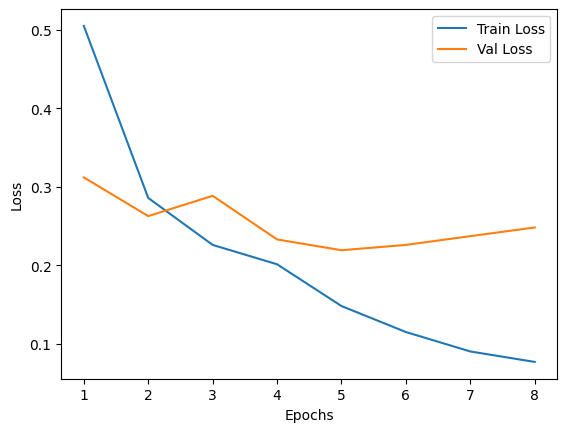

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
lstm_model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_iterator:
        sequences, lengths = batch.body
        labels = batch.label
        predictions = lstm_model(sequences, lengths).squeeze()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# metrics
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

# confusion matrix
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1*100:.2f}%")
print(f"Test ROC AUC: {roc_auc*100:.2f}%")
print(f"False Positive Rate: {fpr*100:.2f}%")
print(f"False Negative Rate: {fnr*100:.2f}%")

Test Accuracy: 93.19%
Test Precision: 93.08%
Test Recall: 93.40%
Test F1 Score: 93.24%
Test ROC AUC: 98.55%
False Positive Rate: 7.03%
False Negative Rate: 6.60%
